<h1>I. Import library and load dataset

In [1]:
import pandas as pd
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
from torch import optim

from sklearn.metrics import f1_score, accuracy_score

import optuna

import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.anomaly import *
import pycaret

import warnings
warnings.filterwarnings('ignore')

In [54]:
transform = transforms.Compose([transforms.RandomRotation(10), transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print("Train batches:", len(trainloader))
print("Test batches:", len(testloader))

Train batches: 938
Test batches: 157


<h1>II. EDA

EDA part is referenced from [[MNIST] Let's see it from a new perspective! (Kaggle)](https://www.kaggle.com/code/ohseokkim/mnist-let-s-see-it-from-a-new-perspective#Checking-Target-Imbalance)


<h2>1. Checking target imbalance

Label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


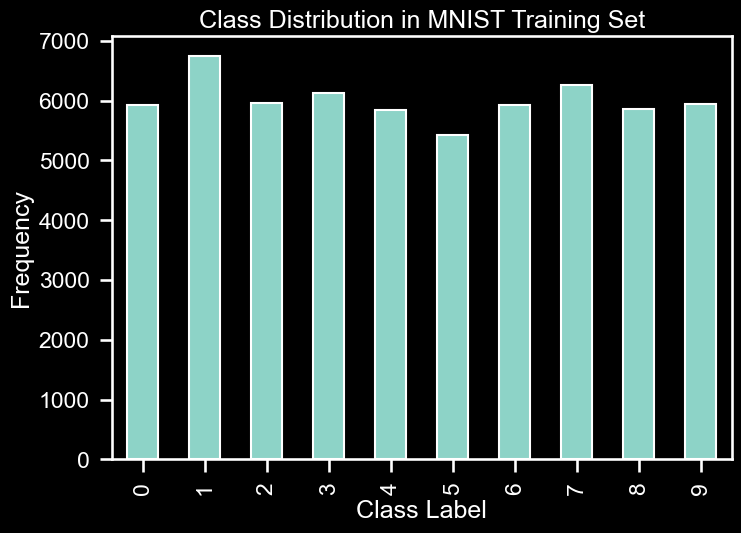

In [55]:
labels_list = trainset.targets.tolist()
df = pd.DataFrame(labels_list, columns=["Label"])
class_counts = df["Label"].value_counts().sort_index()
print(class_counts)

class_counts.plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution in MNIST Training Set')
plt.show()

There is a trivial imbalance in the dataset, so the suitable evaluation metric is accuracy.

<h2>2. Anamoly detection

Using PyCaret to automate setup and execution PCA for anamoly detection 

In [60]:
data = torch.stack([trainset[i][0].view(-1) for i in range(len(trainset))])
data_np = data.numpy()
data_df = pd.DataFrame(data_np)

pycaret.anomaly.setup(data=data_df)

pca = pycaret.anomaly.create_model('pca')
pca_df = pycaret.anomaly.assign_model(pca)

abnormal_data = pca_df[pca_df.Anomaly == 1].sort_values(by='Anomaly_Score', ascending=False)
print("The size of anomalies =", len(abnormal_data))

,Description,Value
0,Session id,7981
1,Original data shape,"(60000, 784)"
2,Transformed data shape,"(60000, 784)"
3,Numeric features,784
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


The size of anomalies = 3000


There are 3000 anomalies. There don't seem to be many outliers.

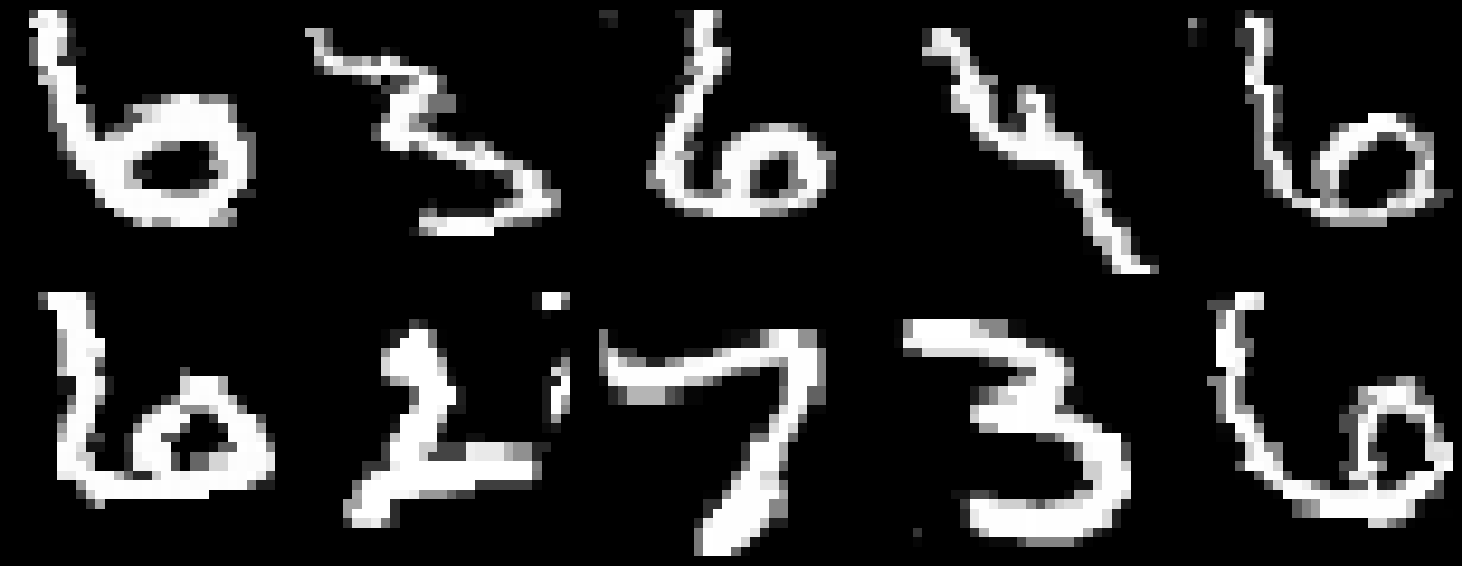

In [61]:
abnormal_data['Label'] = df.loc[abnormal_data.index, 'Label']

indices = abnormal_data.head(10).index
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, idx in enumerate(indices):
    image = data_np[idx].reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Among the outliers, there are pictures that are confusing even with our eyes when looking at the pictures drawn by selecting the top 10 by sorting based on the value of the largest abnormal score.

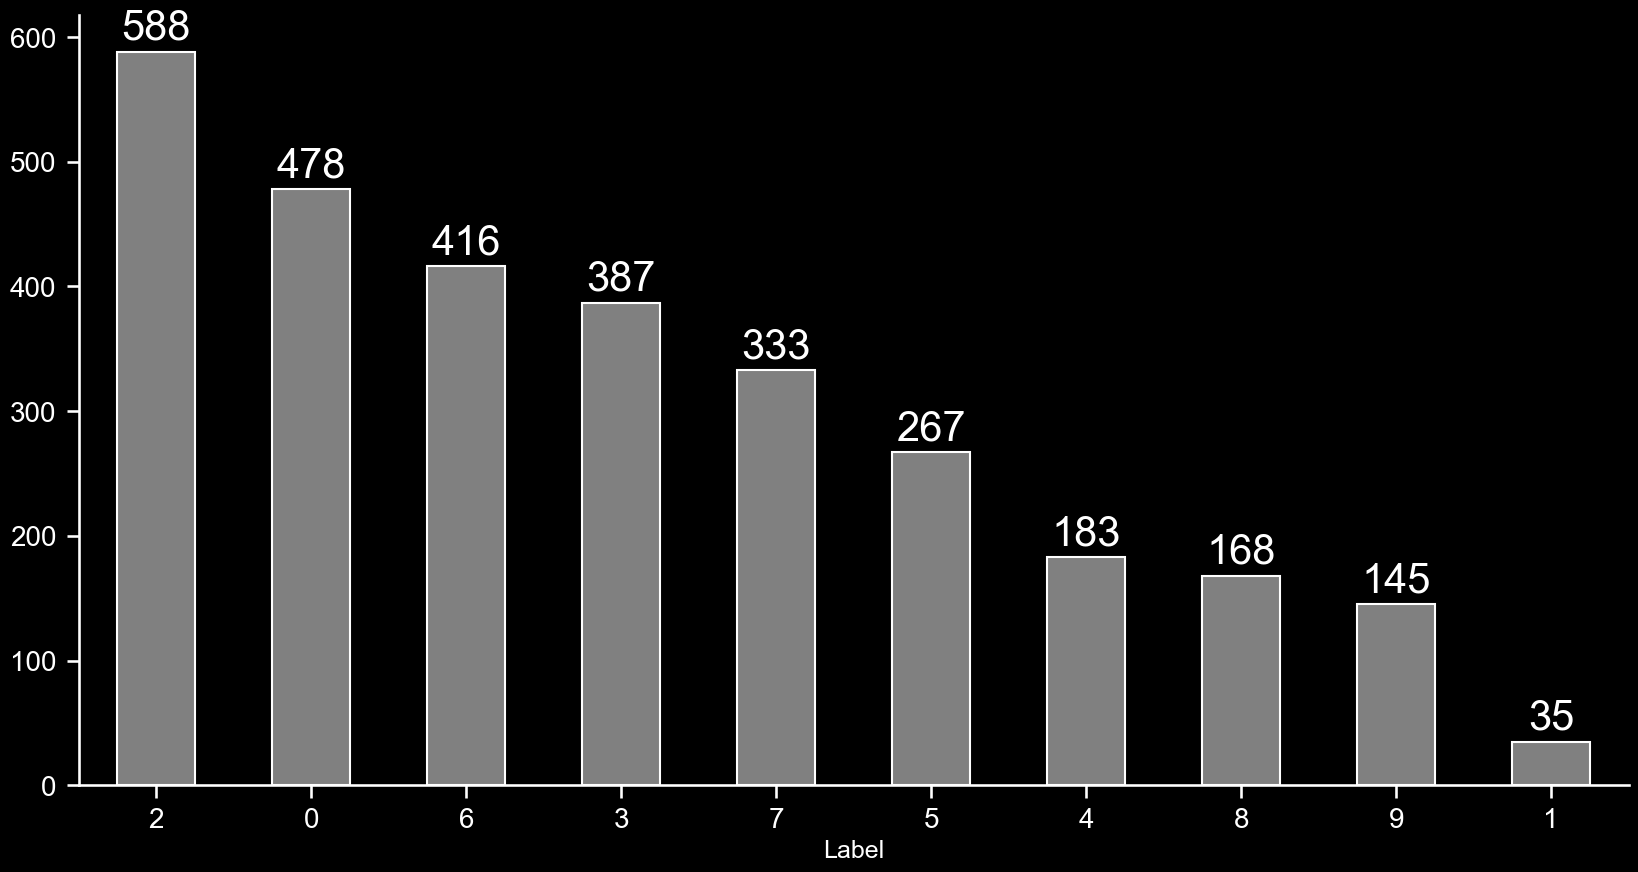

In [58]:
sns.set(style="ticks", context="talk", font_scale=1)
plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
ax = abnormal_data.Label.value_counts().sort_values(ascending=False).plot(kind='bar', grid=False, fontsize=20, color='grey')
plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 10, height, ha='center', size=30)
sns.despine()

- A lot of outliers are seen in the numbers 2, 0 and 6.
- Numbers of 1 seem to have the fewest outliers.

<h1> III. Model

<h2>1. DNN

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,10)
        )

    def forward(self, x):
        return self.model(x)

model = DNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy Score: {accuracy:.4f}")

Epoch 1/10, Loss: 0.4666
Epoch 2/10, Loss: 0.2329
Epoch 3/10, Loss: 0.1864
Epoch 4/10, Loss: 0.1612
Epoch 5/10, Loss: 0.1471
Epoch 6/10, Loss: 0.1331
Epoch 7/10, Loss: 0.1271
Epoch 8/10, Loss: 0.1180
Epoch 9/10, Loss: 0.1119
Epoch 10/10, Loss: 0.1075
Test accuracy Score: 0.9758


The accuracy for the basic DNN model with three hidden layers is 0.9758, which is a pretty good result (based on [MNIST Benchmark](https://paperswithcode.com/sota/image-classification-on-mnist?metric=Accuracy))

<h3>1.1. Tuning

<h4>1.1.1. Hyperparameter tuning

In [ ]:
class DNN(nn.Module):
    def __init__(self, n_layers, n_neurons, dropout_rate):
        super(DNN, self).__init__()
        layers = [nn.Flatten()]
        input_size = 784

        for _ in range(n_layers):
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_size = n_neurons

        layers.append(nn.Linear(input_size, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def objective(trial):
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 512)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    n_neurons = trial.suggest_int('n_neurons', 64, 512)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)

    model = DNN(n_layers, n_neurons, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

    model.train()

    for epoch in range(1):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)
best_params = study.best_params

learning_rate = best_params['lr']
batch_size = best_params['batch_size']
dropout_rate = best_params['dropout_rate']
n_layers = best_params['n_layers']
n_neurons = best_params['n_neurons']

model = DNN(n_layers, n_neurons, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform), batch_size=batch_size, shuffle=False)

model.train()
for epoch in range(10):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

all_targets = []
all_preds = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy Score: {accuracy:.4f}")

[I 2024-12-23 14:48:43,365] A new study created in memory with name: no-name-0705bfb5-d8ff-496b-a227-bb3ea1b5519b
[I 2024-12-23 14:49:00,317] Trial 0 finished with value: 0.2571142017841339 and parameters: {'lr': 0.0016409704651849126, 'batch_size': 380, 'dropout_rate': 0.20371352000681348, 'n_layers': 3, 'n_neurons': 308, 'weight_decay': 2.4591104372844242e-05}. Best is trial 0 with value: 0.2571142017841339.
[I 2024-12-23 14:49:17,441] Trial 1 finished with value: 0.33382880687713623 and parameters: {'lr': 0.00032889943708105056, 'batch_size': 311, 'dropout_rate': 0.3240654459707878, 'n_layers': 1, 'n_neurons': 361, 'weight_decay': 5.2082245647571715e-05}. Best is trial 0 with value: 0.2571142017841339.
[I 2024-12-23 14:49:34,503] Trial 2 finished with value: 2.3009634017944336 and parameters: {'lr': 0.00043900824129748553, 'batch_size': 339, 'dropout_rate': 0.28456139878271036, 'n_layers': 5, 'n_neurons': 202, 'weight_decay': 0.019479678336635636}. Best is trial 0 with value: 0.2571

Best Hyperparameters: {'lr': 0.0016409704651849126, 'batch_size': 380, 'dropout_rate': 0.20371352000681348, 'n_layers': 3, 'n_neurons': 308, 'weight_decay': 2.4591104372844242e-05}
Test accuracy Score: 0.9775


After tuning for five Hyperparameters: learning rate, batch size, dropout rate, n layers, n neurons, and weight decay, the best Hyperparameters fit in models. The result improves just a little: 0.9775, but again, that is still considered a good result.

Optuna is the hyperparameters optimization framework used to find the best hyperparameters.

<h4>1.1.2. Fine tuning

To fit the MNIST dataset to the pre-trained model resnet18, some actions need to be done. These include:
- Resizing the input size to 224x224 to fit with the input size of resnet18.
- Changing the output size of the last layer to 10 since there are 10 classification classes.

In [ ]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

for param in model.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.train()
for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {running_loss / len(trainloader):.4f}")

all_targets = []
all_preds = []

model.eval()
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy Score: {accuracy:.4f}")

Epoch 1/10, Loss: 0.4544
Epoch 2/10, Loss: 0.1744
Epoch 3/10, Loss: 0.1390
Epoch 4/10, Loss: 0.1218
Epoch 5/10, Loss: 0.1097
Epoch 6/10, Loss: 0.1021
Epoch 7/10, Loss: 0.0953
Epoch 8/10, Loss: 0.0910
Epoch 9/10, Loss: 0.0883
Epoch 10/10, Loss: 0.0843
Test Accuracy Score: 0.9731


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(10):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

all_targets = []
all_preds = []

model.eval()
with torch.no_grad():
    for data, target in testloader:
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy Score: {accuracy:.4f}")

Test accuracy Score: 0.9889


The highest accuracy score in this mini code project is accuracy 0.9889

<h2>2. CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  # Output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x14x14

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Output: 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x7x7
        )

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,10)
        )

    def forward(self, x):
        return self.model(x)

model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy Score: {accuracy:.4f}")

Epoch 1/10, Loss: 0.4495
Epoch 2/10, Loss: 0.2403
Epoch 3/10, Loss: 0.2031
Epoch 4/10, Loss: 0.1761
Epoch 5/10, Loss: 0.1669
Epoch 6/10, Loss: 0.1517
Epoch 7/10, Loss: 0.1463
Epoch 8/10, Loss: 0.1362
Epoch 9/10, Loss: 0.1312
Epoch 10/10, Loss: 0.1235
Test accuracy Score: 0.9750


Adding convolutional layers can result in 0.9750 accuracy

<h1>IV. Testing with handwriting digit

Image: 0.png - Predicted label: 9


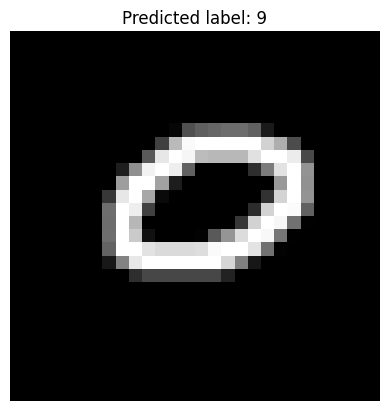

Image: 1.png - Predicted label: 9


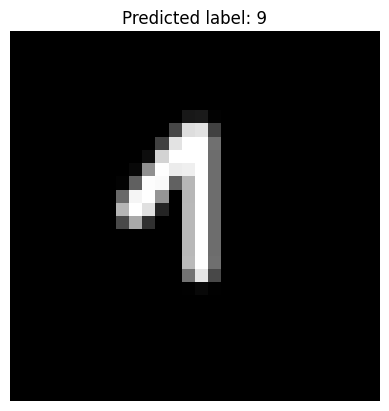

Image: 2.png - Predicted label: 2


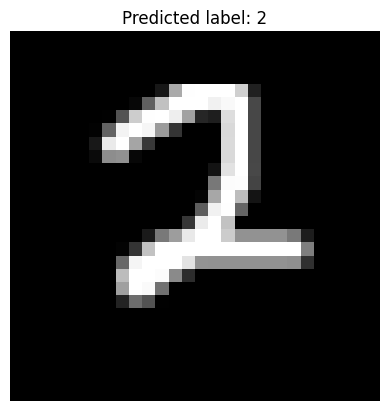

Image: 3.png - Predicted label: 2


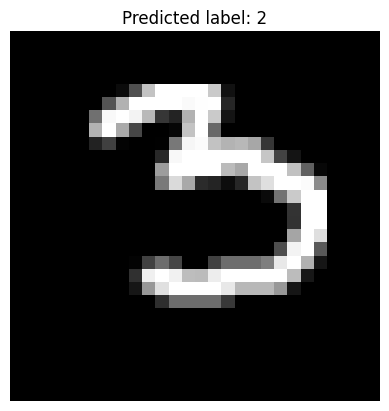

Image: 4.png - Predicted label: 4


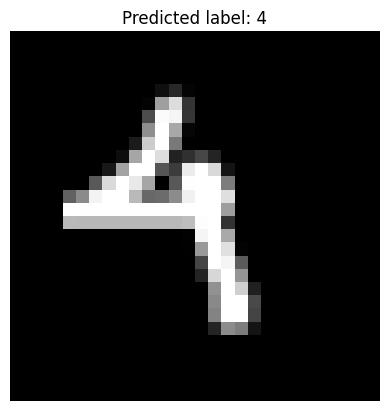

Image: 5.png - Predicted label: 9


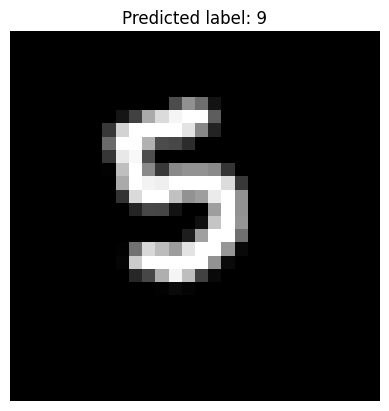

Image: 6.png - Predicted label: 8


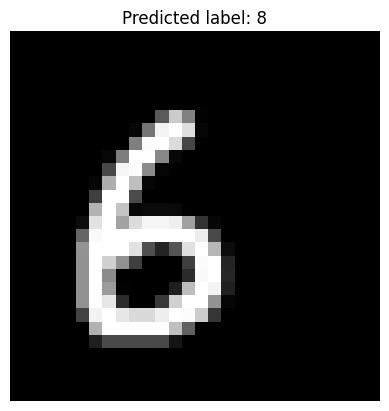

Image: 7.png - Predicted label: 8


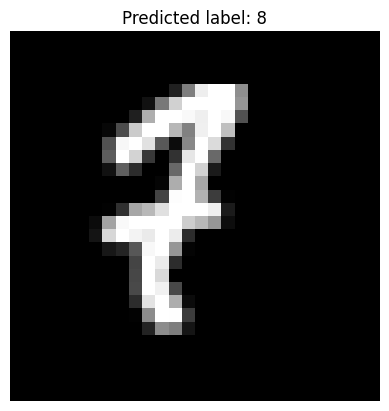

Image: 8.png - Predicted label: 8


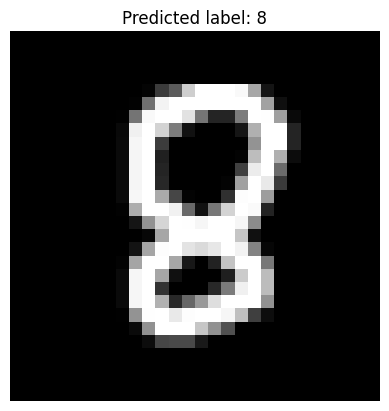

Image: 9.png - Predicted label: 9


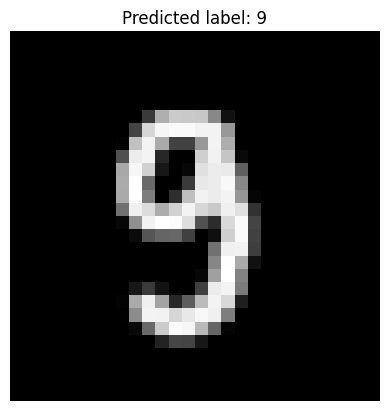

In [ ]:
def process_and_center_image(image_path):
    image = Image.open(image_path).convert('L')

    image = ImageOps.invert(image)

    image.thumbnail((20, 20))
    new_image = Image.new('L', (28, 28), (0))
    new_image.paste(image, ((28 - image.size[0]) // 2, (28 - image.size[1]) // 2))


    image_array = np.array(new_image) / 255.0

    return image_array

image_folder_path = "D:\image - xấu"


image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png')]


processed_images = []
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    processed_image = process_and_center_image(image_path)
    processed_images.append(processed_image)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
input_images = torch.stack([transform(img).float() for img in processed_images])

model.eval()

outputs = model(input_images)
_, predicted = torch.max(outputs, 1)

for img_name, img_data, pred in zip(image_files, processed_images, predicted):
    print(f'Image: {img_name} - Predicted label: {pred.item()}')

    plt.imshow(img_data, cmap='gray')
    plt.title(f'Predicted label: {pred.item()}')
    plt.axis('off')
    plt.show()

The result is only about 5 correct pictures out of 10. The digit will be wrote more carefully to see if the result will get better

Image: 0.png - Predicted label: 0


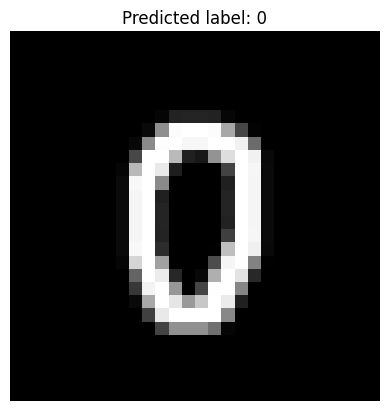

Image: 1.png - Predicted label: 1


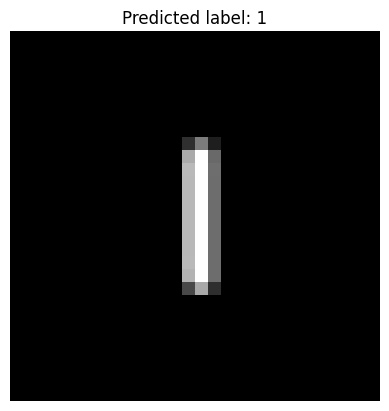

Image: 2.png - Predicted label: 2


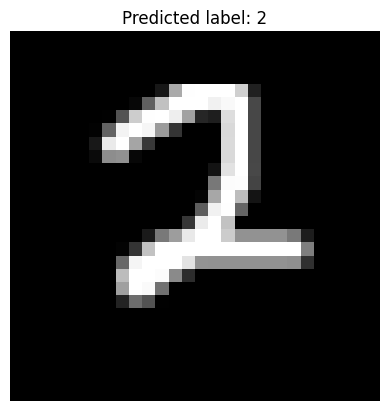

Image: 3.png - Predicted label: 9


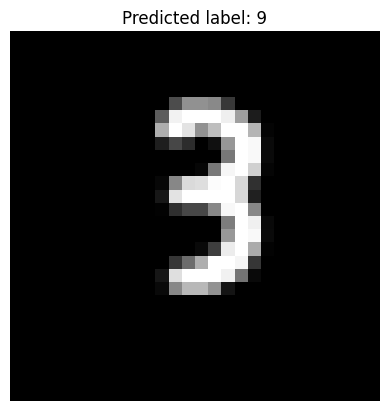

Image: 4.png - Predicted label: 4


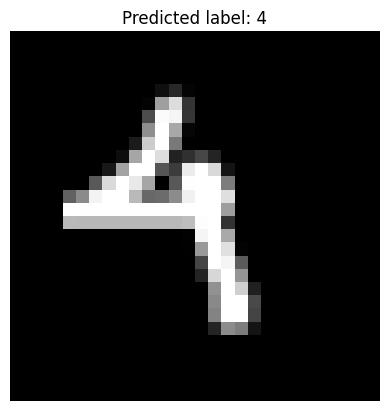

Image: 5.png - Predicted label: 9


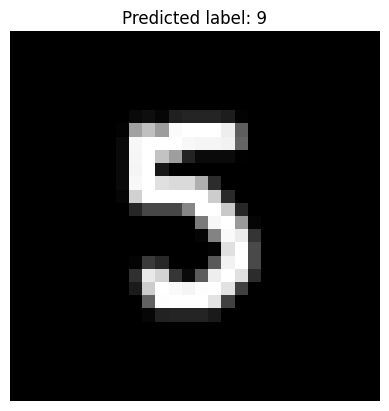

Image: 6.png - Predicted label: 6


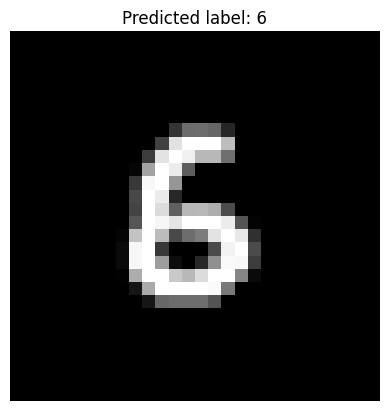

Image: 7.png - Predicted label: 7


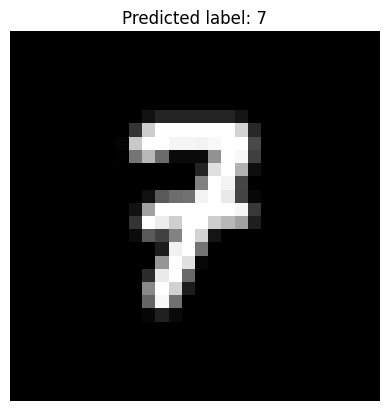

Image: 8.png - Predicted label: 8


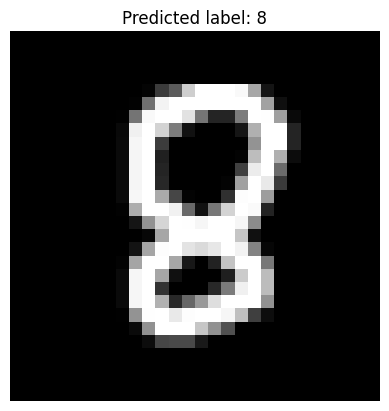

Image: 9.png - Predicted label: 9


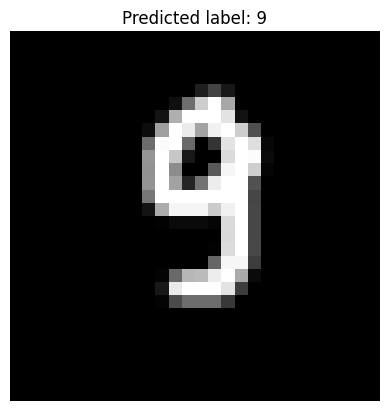

In [ ]:
image_folder_path = "D:\image - đẹp"


image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png')]


processed_images = []
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    processed_image = process_and_center_image(image_path)
    processed_images.append(processed_image)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
input_images = torch.stack([transform(img).float() for img in processed_images])

model.eval()

outputs = model(input_images)
_, predicted = torch.max(outputs, 1)

for img_name, img_data, pred in zip(image_files, processed_images, predicted):
    print(f'Image: {img_name} - Predicted label: {pred.item()}')

    plt.imshow(img_data, cmap='gray')
    plt.title(f'Predicted label: {pred.item()}')
    plt.axis('off')
    plt.show()

 If digigit are written carefully and change into right format (centered, gayscale, ...), the predicted results is much better (8/10 pictures are correctly predicted)